# <center>Projeto de Redes Neurais Artificiais</center>
## <center>Detecção e Classificação de Gestos</center>
#### <left>Autor: Pedro Antônio de Souza Silva</left>
#### <left>Contato: panssfancy@gmail.com</left>
---

#### <center>Imports Necessários</center>

In [4]:
# Redes neurais, funções de ativação, otimizadores e tensores
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Dados, Conjuntos e Transformações
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import string # para a construção de um dicionário essencial ao sistema
# io do Sistema Operacional (para ler base de dados)
import os
from os import walk
# Manipulação Gráfica (para plotar imagens e gráficos) e randomizações
from skimage import transform # função para modificar facilmente o tamanho de uma imagem
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime

---
- **Vamos começar pelo Tratamento de Dados**
 - <i>Base de Dados: <u>[Massey Gesture Dataset](https://www.massey.ac.nz/~albarcza/gesture_dataset2012.html)</u></i>
 - É uma base de dados formada por **2515** imagens RGB de gestos no total (5 partes somadas)
 - As imagens são de **mãos sobre fundo preto** em gestos correspondentes a **números** [0 a 9] e **letras** [A a Z]
 - A **label** de cada imagem **está no nome do arquivo**, similar a: **<i>mão4_(LABEL)_etc_etc_etc_cropped.png</i>**
 - A label é um único caractere.

1. Definindo a Classe -> **DatasetMassey (herda de torch.utils.data.Dataset)**

In [5]:
class DatasetMassey(Dataset):
    def __init__(self,raiz='Massey/handgestures_combinado/', transform=None):
        #construtor da superclasse
        super(DatasetMassey, self).__init__()
        #ler dados
        self.x = []
        self.y = []
        self.transform = transform
        self.raiz = raiz
        # loops para leitura de dados e preenchimento de X(dado) e Y(label)
        for (_, _, filenames) in walk(raiz):
            self.x.extend(sorted(filenames)) # adiciona o nome de arquivo a X
            break
        # para cada exemplo de X, pegue a label e armazene no dataset
        for exemplo in self.x:
            self.y.extend(exemplo[6])
        
        #armazene o tamanho do dataset
        self.n_amostras = len(self.x)
        self.n_classes = np.unique(self.y)
        
    def __getitem__(self, indice):
        # Só aqui no GetItem, as imagens serão lidas de fato
        # Isso ajuda na eficiência de memória e tempo, pois só lemos e carregamos do disco ao precisarmos delas
        
        caminho_de_arquivo = os.path.join(self.raiz, self.x[indice])
        amostra = {'imagem':plt.imread(caminho_de_arquivo),'label':self.y[indice]}
        
        if self.transform:
            amostra = self.transform(amostra)
        
        return amostra
    
    def __len__(self):
        return self.n_amostras


2. Testando nosso Dataset customizado:

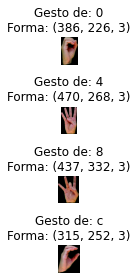

Tamanho do Dataset: 2515


In [6]:
# Instanciar
dataset = DatasetMassey()

# Recuperar um Item
for i in range(4):
    amostra = dataset.__getitem__(i*100)
    ax = plt.subplot(4,1,i+1)
    ax.set_title("Gesto de: "+str(amostra['label'])+"\nForma: "+str(amostra['imagem'].shape))
    ax.axis('off')
    ax.imshow(amostra['imagem'])
plt.tight_layout()
plt.show()

# Tamanho
print("Tamanho do Dataset: " + str(len(dataset)))

In [7]:
maior_h = 0
maior_w = 0

menor_h = 1000
menor_w = 1000

for i in range(len(dataset)):
    amostra = dataset[i]
    imagem = amostra['imagem']
    forma = imagem.shape
    
    if (forma[0] > maior_h):
        maior_h = forma[0]
    elif (forma[0] < menor_h):
        menor_h = forma[0]     
    
    if (forma[1] > maior_w):
        maior_w = forma[1]
    elif (forma[1] < menor_w):
        menor_w = forma[1]    
        
print(f'Maiores Valores: h:{maior_h} * w:{maior_w}')
print(f'Menores Valores: h:{menor_h} * w:{menor_w}')

Maiores Valores: h:660 * w:590
Menores Valores: h:177 * w:179


3. Podemos ver que o nosso Dataset precisa de algumas transformações, pois as **imagens tem dimensões diferentes.**
    - <i>Redes Neurais normalmente trabalham com imagens de dimensões iguais.</i>

4. Vamos definir algumas transformações necessárias para nosso DataSet:
    1. **Rescale**: Modificar a escala da imagem para um formato fixo
    2. **ToTensor**: Transformar as imagens em torch.Tensor

In [8]:
class MinhaRescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
   
    def __call__(self, amostra):
        imagem, label = amostra['imagem'], amostra['label']
        h, w = imagem.shape[:2]
        
        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(imagem, (new_h, new_w))
        label = label
        return {'imagem': img, 'label': label}


---
- As Labels são **strings**, para usarmos strings como tensores, precisamos **transformá-las em números**
    - Vamos Utilizar Dicionários.
    - Um número -> Uma Classe
    - Definido o dicionário como:
        - Chaves[0-9] -> Números [0-9]
        - Chaves[10-]
- As Imagens são **imagens do Numpy**, precisamos transformá-las em **imagens do Pytorch**
    - Para serem tratadas como Tensores, precisamos transpor o número de canais como o primeiro índice

In [9]:
class ToTensor(object):
    def __init__(self):
        # Cria uma lista com os caracteres em lowercase
        letras = list(string.ascii_lowercase)
        
        # Cria uma lista com os dígitos numéricos decimais
        numeros = list(string.digits)
        
        # Cria a lista unida de Dígitos e Letras (Que é todo o nosso conjunto de labels do Massey)
        A_Grande_Lista = numeros+letras
        
        # Cria um dicionário vazio que será preenchido, mapeando Label -> índice numérico
        self.O_Grande_Dicionario = dict()
        
#         print(A_Grande_Lista)

        # Preenche o dicionário, mapeando cada item da lista de labels para um índice numérico
        for i in range(len(A_Grande_Lista)):
            self.O_Grande_Dicionario[A_Grande_Lista[i]] = i
            if(i>=len(numeros)):
                self.O_Grande_Dicionario[i] = A_Grande_Lista[i]
        
#         print(self.O_Grande_Dicionario)
        
    def __call__(self, amostra):
        imagem, label = amostra['imagem'], amostra['label']
        # Sobre a Label
            # Devemos trocar a String por seu índice numérico no dicionário
            # Com o índice numérico podemos transformar em um torch.Tensor
        label = self.O_Grande_Dicionario[label]
        label = torch.tensor(label)
        
        # Sobre a Imagem
            # Devemos Trocar os eixos pois:
            # imagem numpy: H x W x Canais
            # imagem torch: Canais X H X W
        imagem = imagem.transpose((2, 0, 1))
        
        # Retorno da Tupla de Tensores
        return {'imagem': torch.from_numpy(imagem),
                'label': label}
    
    # Função que retorna O Grande Dicionario
    def getDicionario(self):
        return self.O_Grande_Dicionario
    
    # Função que converte label de volta para String
        # Só serve pra verificar se tá tudo OK
    def TensorString(self, tensor):
        item = tensor.item()
        if( item > 9):
            return self.O_Grande_Dicionario[item]
        else:
            return str(item)

---
 - Esta transformação abaixo servirá apenas para transformar ***Tensores de imagens*** em ***imagens Numpy***

In [10]:
class ToNumpyImage(object):
    def __call__(self, tensor_imagem):
        imagem = tensor_imagem.permute(1, 2, 0)
        return imagem

---
- Testando a transformação **MinhaScale** para **Resolução=(32,32)**

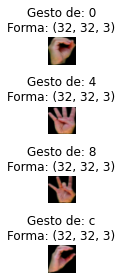

In [11]:
scale = MinhaRescale((32,32))

for i in range(4):
    amostra = scale(dataset[i*100])
    ax = plt.subplot(4,1,i+1)
    ax.set_title("Gesto de: "+str(amostra['label'])+"\nForma: "+str(amostra['imagem'].shape))
    ax.axis('off')
    ax.imshow(amostra['imagem'])
plt.tight_layout()
plt.show()

---
- Testando a transformação **ToTensor** e a <u>Composta</u> **ToTensor(Scale(Amostra))**

In [12]:
# Instanciando MinhaRescale para resolução 32x32
scale = MinhaRescale((32,32))

# Instanciando ToTensor()
t = ToTensor()

# Composição é uma transformação -> MinhaRescale(32,32) -> ToTensor()
composta = transforms.Compose([scale,t])

###### Teste ToTensor()

In [13]:
amostra = dataset[500]
print("Antes de ToTensor()\t| ","Tipo da Imagem:",type(amostra['imagem']),"\t|\tTipo da Label",type(amostra['label']))

amostra = t(amostra)
print("Após o ToTensor()\t| ","Tipo da Imagem:",type(amostra['imagem']),"\t|\tTipo da Label",type(amostra['label']))

# dicionario = t.getDicionario()
# print("Dicionário do ToTensor")
# for x in dicionario.keys():
#     print(x,":",dicionario[x])
    

Antes de ToTensor()	|  Tipo da Imagem: <class 'numpy.ndarray'> 	|	Tipo da Label <class 'str'>
Após o ToTensor()	|  Tipo da Imagem: <class 'torch.Tensor'> 	|	Tipo da Label <class 'torch.Tensor'>


###### Composta()

Dimensões torch.Size([3, 32, 32]) 	|	Tipo: <class 'torch.Tensor'> 	|	Label:  tensor(0) = 0
Dimensões torch.Size([3, 32, 32]) 	|	Tipo: <class 'torch.Tensor'> 	|	Label:  tensor(4) = 4
Dimensões torch.Size([3, 32, 32]) 	|	Tipo: <class 'torch.Tensor'> 	|	Label:  tensor(8) = 8
Dimensões torch.Size([3, 32, 32]) 	|	Tipo: <class 'torch.Tensor'> 	|	Label:  tensor(12) = c


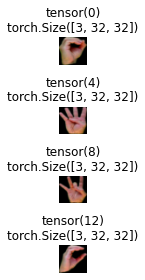

In [14]:
for i in range(4):
    amostra = composta(dataset[i*100])
    ax = plt.subplot(4,1,i+1)
    ax.set_title(str(amostra['label'])+"\n"+str(amostra['imagem'].shape))
    ax.axis('off')
    # De Imagem Tensor para Imagem Numpy:
    imagem_np = amostra['imagem']
    
    print("Dimensões",imagem_np.shape,"\t|\tTipo:", type(imagem_np),"\t|\tLabel: ",amostra['label'],"=",t.TensorString(amostra['label']))
    
    plt.imshow(imagem_np.permute(1, 2, 0))
    
plt.tight_layout()
plt.show()


5. Como a <i>composta</i> funcionou, podemos reabrir o nosso DataSet passando ela como parâmetro.
 - Agora as imagens serão tensores com o mesmo tamanho.

In [15]:
# Definindo a Transformação a ser utilizada
transformação = transforms.Compose([MinhaRescale((32,32)),ToTensor()])

# Instanciando Novo DataSet
dataset = DatasetMassey(raiz="Massey/handgestures_combinado/",transform=transformação)

---
##### <center>Testando Dataset com Transformador:</center>

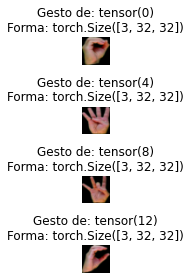

Tamanho do Dataset: 2515


In [16]:
para_np = ToNumpyImage()

for i in range(4):
    amostra = dataset[i*100]
    ax = plt.subplot(4,1,i+1)
    ax.set_title("Gesto de: "+str(amostra['label'])+"\nForma: "+str(amostra['imagem'].shape))
    ax.axis('off')
    ax.imshow(para_np(amostra['imagem']))

plt.tight_layout()
plt.show()

# Tamanho
print("Tamanho do Dataset: " + str(len(dataset)))

### <center>Finalmente! Temos um Dataset Funcional</center>
---
#### - Agora podemos implementar um **DataLoader** para a base.
 - Com o DataLoader podemos automatizar:
     - <i>Batching
     - Shuffling
     - Paralelização de Leitura
     - Sampler

#### <center>Parâmetros para Construção do <i>DataLoader</i> e <i>Samplers</i></center>

In [17]:
# Tamanho do batch a ser utilizado (o DataLoader vai usar este tamanho de batch)
tamanho_batch = 4

# Deve-se misturar e aleatorizar a ordem dos índices do DataSet? (Para um bom Sampler, SIM)
bagunçar = True

# Número de leitores simultâneos para o DataSet (Se sua máquina aguentar,a paralelização vai agilizar as leituras)
numero_threads = 1

# Porcentagem do Dataset a ser separado para o conjunto de validação (PARÂMETRO IMPORTANTÍSSIMO) -> padrão de 20%
porcentagem_split = .2

# Um número qualquer para iniciar uma randomização (uma simples seed para random)
seed_randomização = 42

---
#### <center>Separando os Conjuntos</center>

In [18]:
# Lista dos índices do Dataset
indices = list(range(len(dataset)))

# Chão da Porcentagem * Tamanho do Dataset
split = int(np.floor(porcentagem_split * len(dataset)))

# Se é para Bagunçaro Dataset, então bagunce a ordem os índices da lista com base na semente randomica
if bagunçar :
    np.random.seed(seed_randomização)
    np.random.shuffle(indices)

# indices de treino recebe os primeiros SPLIT indices randomizados, os de validação recebem o resto
indices_treino, indices_validação = indices[split:], indices[:split]

#### <center>Conjuntos Separados</center>

In [19]:
print(f'Quantidade de Exemplos para Treinamento: {len(indices_treino)}\nQuantidade de Exemplos para Validação: {len(indices_validação)}')

Quantidade de Exemplos para Treinamento: 2012
Quantidade de Exemplos para Validação: 503


---
- Definindo **Samplers** e **DataLoaders** para os conjuntos de Dados
 - **Samplers** definem os índices ou sequências de dados a serem utilizados no DataLoader
 - **DataLoaders** automatizam acessos e operações sobre o conjunto de dados

In [20]:
sampler_treino = SubsetRandomSampler(indices_treino)
sampler_validação = SubsetRandomSampler(indices_validação)

In [21]:
loader_treino = torch.utils.data.DataLoader(dataset, batch_size=tamanho_batch, sampler=sampler_treino)
loader_validação = torch.utils.data.DataLoader(dataset,batch_size=tamanho_batch, sampler=sampler_validação)

# EXEMPLO DE USO

In [22]:
# numero_epocas = 10
# for epoca in range(numero_epocas):
#     # TREINO:   
#     for indice_batch, (imagens, labels) in enumerate(loader_treino):
#         # CÓDIGO DE TREINO

---
### <center>Construindo a Neural Convolucional</center>

---
###### Primeiramente, vamos verificar se é possível calcular na GPU , pois na CPU  será muito mais lento.

In [23]:
# Se a GPU estiver disponível, ela será nosso dispositivo de trabalho, se não, vamos ter que usar a coitada da CPU
dispositivo = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Utilizando:",dispositivo)

Utilizando: cuda


---
#### <center>Estrutura da Rede</center>
- As camadas convolucionais são 2D, pois os dados tratados aqui são imagens.

In [24]:
class RedeConvolucional_Gestos(nn.Module):
    def __init__(self, n_classes):
        super(RedeConvolucional_Gestos,self).__init__()
        
        # Armazena numero de classes do problema
        self.n_classes = n_classes
        
        # Função de Pool que será usada na Rede -> Kernel_Size = 2 , Stride = 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Primeira camada
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels= 6, kernel_size=5)
            
        # Segunda camada
        self.conv2 = nn.Conv2d(in_channels= 6, out_channels= 16, kernel_size=5)
        
        # Treceira camada
        self.conv3 = nn.Conv2d(in_channels= 16, out_channels= 120 , kernel_size=5)
        
        # Primeira camada FC
        self.fc1 = nn.Linear(in_features= 120, out_features= 84)
        
        # Segunda camada FC
        self.fc2 = nn.Linear(in_features=84, out_features= self.n_classes)
        
    def forward(self,entrada):
        
#         print("Formato da Entrada: ",entrada.shape)
        
        saida = self.conv1(entrada)
        saida = F.relu(saida)
        saida = self.pool(saida)
        
#         print("Formato após Conv1+relu+pool: ",saida.shape)
        
        saida = self.conv2(saida)
        saida = F.relu(saida)
        saida = self.pool(saida)
        
#         print("Formato após Conv2+relu+pool: ",saida.shape)
        
        saida = self.conv3(saida)
        saida = F.relu(saida)
        
#         print("Formato após Conv3+relu: ",saida.shape)
        
        saida = saida.view(-1,120)
        
#         print(saida.shape)
        
        saida = self.fc1(saida)
        saida = F.relu(saida)
        
#         print(saida.shape)
        
        saida = self.fc2(saida)
        
#         print(saida.shape)
        
        return saida

In [25]:
# Instanciando e passando para a GPU (ou CPU)
minha_rede = RedeConvolucional_Gestos(36).to(dispositivo)

In [26]:
print(minha_rede)

RedeConvolucional_Gestos(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=36, bias=True)
)


---
## <center>Treinando a Rede</center>
#### <center>Parâmetros do Treinamento</center>

In [27]:
taxa_de_aprendizado = 0.01

criterio_avaliativo = nn.CrossEntropyLoss()

otimizador = torch.optim.SGD(minha_rede.parameters(),lr = taxa_de_aprendizado)

num_epocas = 0

num_passos = len(loader_treino)

In [28]:
print("Iniciando Treinamento")

num_passos = len(loader_treino)

for epoca in range(num_epocas):
    for passo, amostra in enumerate(loader_treino):
        # Setup
            # Passando imagens e suas respectivas labels para a GPU (ou cpu)
        imagens = amostra['imagem'].to(dispositivo)
        labels = amostra['label'].to(dispositivo)
        # Forward
            # Calculando as induções e o custo
        saidas = minha_rede(imagens)
        custo = criterio_avaliativo(saidas,labels)
        # Backward
            # Otimizando
        otimizador.zero_grad()
        custo.backward()
        otimizador.step()
        # Reportar progresso
        if (passo+1)%100 == 0:
            print(f'Época [ {epoca+1} / {num_epocas} ]\t|\tPasso [ {passo+1:3} / {num_passos} ]\t|\tCusto [ {custo} ]')

print("Fim do Treinamento")

Iniciando Treinamento
Fim do Treinamento


---
## <center>Calculando Precisão da Rede</center>

In [29]:
with torch.no_grad():
    n_corretos = 0
    n_amostras = 0
    n_classe_correta = [0 for i in range(36)]
    n_amostra_classe = [0 for i in range(36)]
    
    for amostra in loader_validação:
        imagens = amostra['imagem'].to(dispositivo)
        labels = amostra['label'].to(dispositivo)
        # Precisão Geral da Rede
        saidas = minha_rede(imagens)
        _, predição = torch.max(saidas,1)
        n_amostras += labels.size(0)
        n_corretos += (predição == labels).sum().item()
        # Precisão Para cada Classe da Rede
        for i in range(len(labels)):
            label = labels[i]
            pred = predição[i]
            if (label == pred):
                n_classe_correta[label] += 1
            n_amostra_classe[label] +=1
        
        
    # calc de precisão geral
    precisão = 100.0 * n_corretos / n_amostras
    print(f'Precisão Geral sobre o Conjunto de Validação [ {precisão}% ]')    
    
    # calc de precisão para cada classe
    for i in range(36):
        precisão_classe = 100.0 * n_classe_correta[i] / n_amostra_classe[i]
        classe = t.TensorString(torch.tensor([i]))
        print(f'Precisão para a Classe [ {classe} = {precisão_classe}% ]')    
        
    

Precisão Geral sobre o Conjunto de Validação [ 3.7773359840954273% ]
Precisão para a Classe [ 0 = 0.0% ]
Precisão para a Classe [ 1 = 0.0% ]
Precisão para a Classe [ 2 = 0.0% ]
Precisão para a Classe [ 3 = 0.0% ]
Precisão para a Classe [ 4 = 0.0% ]
Precisão para a Classe [ 5 = 0.0% ]
Precisão para a Classe [ 6 = 0.0% ]
Precisão para a Classe [ 7 = 0.0% ]
Precisão para a Classe [ 8 = 0.0% ]
Precisão para a Classe [ 9 = 100.0% ]
Precisão para a Classe [ a = 0.0% ]
Precisão para a Classe [ b = 0.0% ]
Precisão para a Classe [ c = 0.0% ]
Precisão para a Classe [ d = 0.0% ]
Precisão para a Classe [ e = 0.0% ]
Precisão para a Classe [ f = 0.0% ]
Precisão para a Classe [ g = 0.0% ]
Precisão para a Classe [ h = 0.0% ]
Precisão para a Classe [ i = 0.0% ]
Precisão para a Classe [ j = 0.0% ]
Precisão para a Classe [ k = 0.0% ]
Precisão para a Classe [ l = 0.0% ]
Precisão para a Classe [ m = 0.0% ]
Precisão para a Classe [ n = 0.0% ]
Precisão para a Classe [ o = 0.0% ]
Precisão para a Classe [ p = 

---
# <center>Perfeito, Agora Podemos Salvar o Modelo</center>

- **Salvando:**

In [30]:
# Salvar Modelo em "caminho"
torch.save(minha_rede,'Primeira_CNN_Funcional')

- **Lendo:**

In [31]:
# Ler Modelo de "caminho"
essa_rede=torch.load('Primeira_CNN_Funcional')

- **Testando**:

In [32]:
print(essa_rede)

RedeConvolucional_Gestos(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=36, bias=True)
)


---
# <center>Automatizar</center>

- Este código serve para automatizar as tarefas de:
    1. Criar DataLoaders com diferentes parâmetros
    2. Treinar Redes utilizando diferentes parâmetros
        - Armazenar os Reports de cada rede em arquivos
            - Salvar cada rede em um arquivo com seu nome *(índice)*

In [74]:
r = MinhaRescale((32,32))
t = ToTensor()
composta = transforms.Compose([r,t])

massey = DatasetMassey(transform=composta)

### 1. Automatização de criação dos Dataloaders:

In [75]:
def CriarDataloaders(dataset=None, tamanho_batch=4, bagunçar=True, porcentagem_split=.2):
    
    if dataset is not None:   
        string_report = "\nDataloaders [Teste e Treino]: tamanho_batch="+str(tamanho_batch)+", bagunçar="+str(bagunçar)

        dataset = dataset

        indices = list(range(len(dataset)))

        split = int(np.floor(porcentagem_split * len(dataset)))

        if bagunçar :
            # INICIA O RANDOMIZADOR NUMPY COM SEMENTE = TEMPO ATUAL DO PC
            np.random.seed(random.seed(datetime.now()))
            # MISTURA OS INDICES
            np.random.shuffle(indices)

        indices_treino, indices_validação = indices[split:], indices[:split]

        sampler_treino = SubsetRandomSampler(indices_treino)
        sampler_validação = SubsetRandomSampler(indices_validação)

        loader_treino = torch.utils.data.DataLoader(dataset, batch_size=tamanho_batch, sampler=sampler_treino)
        loader_validação = torch.utils.data.DataLoader(dataset,batch_size=tamanho_batch, sampler=sampler_validação)

        return loader_treino, loader_validação, string_report
    else:
        print("Sem dataset = sem dados, sem dados = sem dataloaders")
        return None,None,None

### 2. Automatização dos Treinos de Redes e Escrita dos Reports

In [76]:
def CalcularPrecisão(Rede=None):
    minha_rede = Rede
    with torch.no_grad():
        n_corretos = 0
        n_amostras = 0
        n_classe_correta = [0 for i in range(36)]
        n_amostra_classe = [0 for i in range(36)]

        for amostra in loader_validação:
            imagens = amostra['imagem'].to(dispositivo)
            labels = amostra['label'].to(dispositivo)
            # Precisão Geral da Rede
            saidas = minha_rede(imagens)
            _, predição = torch.max(saidas,1)
            n_amostras += labels.size(0)
            n_corretos += (predição == labels).sum().item()
            # Precisão Para cada Classe da Rede
            for i in range(len(labels)):
                label = labels[i]
                pred = predição[i]
                if (label == pred):
                    n_classe_correta[label] += 1
                n_amostra_classe[label] +=1


        # calc de precisão geral      
        report="\n"
        precisão = 100.0 * n_corretos / n_amostras
        report+=f'Precisão Geral sobre o Conjunto de Validação [ {precisão}% ]'

        # calc de precisão para cada classe
        for i in range(36):
            precisão_classe = 100.0 * n_classe_correta[i] / n_amostra_classe[i]
            classe = t.TensorString(torch.tensor([i]))
            report+=f'Precisão para a Classe [ {classe} = {precisão_classe}% ]'+"\n"

        return report

In [79]:
def Trinta_Execuções(num_epocas=50,lista_lr=[0.1,0.01,0.001,0.0001,0.00001],criterio=nn.CrossEntropyLoss(),dataset=None,num_execuções=30, loader_treino=None,loader_validação=None):
   # Setup da função
    if dataset is not None: 
    
        dispositivo = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("Utilizando",dispositivo)
        criterio_avaliativo=criterio
        
        # Esta variável armazena uma lista de taxas de aprendizagem, que serão usadas (uma por execução) de forma cíclica
        lista_lr = lista_lr
        indice = 0
        
        for execução in range(num_execuções):
            # Esta variável report vai guardar informações sobre o treino e os resultados, é resetada a cada execução
            report = ""
            
            # Uma nova rede é criada a cada execução
            rede = RedeConvolucional_Gestos(36).to(dispositivo)
            
            # Um novo otimizador é criado a cada execução, com uma nova taxa de aprendizado
            lr = lista_lr[indice]
            otimizador = torch.optim.SGD(minha_rede.parameters(),lr = lr)
            indice +=1
            indice %=  len(lista_lr)
            
            report+="Número de Épocas: "+str(num_epocas)+"\nTaxa de Aprendizado: "+str(lr)+"\nOtimizador: "+str(otimizador)
            
            
            print("Iniciando Treinamento - ",execução+1)

            num_passos = len(loader_treino)

            for epoca in range(num_epocas):
                for passo, amostra in enumerate(loader_treino):
                    # Setup
                        # Passando imagens e suas respectivas labels para a GPU (ou cpu)
                    imagens = amostra['imagem'].to(dispositivo)
                    labels = amostra['label'].to(dispositivo)
                    # Forward
                        # Calculando as induções e o custo
                    saidas = minha_rede(imagens)
                    custo = criterio_avaliativo(saidas,labels)
                    # Backward
                        # Otimizando
                    otimizador.zero_grad()
                    custo.backward()
                    otimizador.step()
                    # Reportar progresso
                    if (passo+1)%100 == 0:
                        print(f'Época [ {epoca+1} / {num_epocas} ]\t|\tPasso [ {passo+1:3} / {num_passos} ]\t|\tCusto [ {custo} ]')

            print("Fim do Treinamento - ",execução+1)
            report +="\n"+str(rede)+"\n"
            torch.save(minha_rede,'{}-{}'.format("Rede_Exec",execução))
            print("Iniciando Cálculo de Precisão")
            report += CalcularPrecisão(minha_rede)
            print("Finalizando Cálculo de Precisão")
            f= open('{}-{}.txt'.format("Report_Exec",execução),'w')
            f.write(report)
            f.close()
        print("Execuções Finalizadas --- FIM")
    else:
        print("Sem rede, sem treinamento")

###### Executando e Escrevendo os Reports (30 execuções, variando -> Taxa de Aprendizado, Batch Size)

In [80]:
loader_treino,loader_validação,report = CriarDataloaders(dataset=dataset,tamanho_batch=64,bagunçar=True,porcentagem_split=.2)
Trinta_Execuções(num_epocas=50,criterio=nn.CrossEntropyLoss(),dataset=massey,num_execuções=30,loader_treino=loader_treino,loader_validação=loader_validação)

Utilizando cuda
Iniciando Treinamento -  1
Fim do Treinamento -  1
Iniciando Cálculo de Precisão
Finalizando Cálculo de Precisão
Iniciando Treinamento -  2
Fim do Treinamento -  2
Iniciando Cálculo de Precisão
Finalizando Cálculo de Precisão
Iniciando Treinamento -  3
Fim do Treinamento -  3
Iniciando Cálculo de Precisão
Finalizando Cálculo de Precisão
Iniciando Treinamento -  4
Fim do Treinamento -  4
Iniciando Cálculo de Precisão
Finalizando Cálculo de Precisão
Iniciando Treinamento -  5
Fim do Treinamento -  5
Iniciando Cálculo de Precisão
Finalizando Cálculo de Precisão
Iniciando Treinamento -  6
Fim do Treinamento -  6
Iniciando Cálculo de Precisão
Finalizando Cálculo de Precisão
Iniciando Treinamento -  7
Fim do Treinamento -  7
Iniciando Cálculo de Precisão
Finalizando Cálculo de Precisão
Iniciando Treinamento -  8
Fim do Treinamento -  8
Iniciando Cálculo de Precisão
Finalizando Cálculo de Precisão
Iniciando Treinamento -  9
Fim do Treinamento -  9
Iniciando Cálculo de Precisão